# Minerador de dados horários das estações de poluição da CETESB

In [2]:
# Dependências 

import requests as req
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import threading as th
from lxml import html
import pylab
pylab.rcParams['figure.figsize'] = (15, 5)

In [3]:
URI1 = "http://sistemasinter.cetesb.sp.gov.br/Ar/php/ar_dados_horarios_resultado.php"
URI2 = "http://sistemasinter.cetesb.sp.gov.br/Ar/php/ar_dados_horarios_Metrl.php"

In [4]:
texDataset = {"Americana":"52/Americana","Araçatuba":"72/Araçatuba","Araraquara":"71/Araraquara",
              "Bauru":"73/Bauru","Campinas-Centro":"42/Campinas-Centro","Campinas-Taquaral":"41/Campinas-Taquaral",
              "Campinas-V.União":"43/Campinas-V.União","Capão Redondo":"37/Capão Redondo","Carapicuíba":"28/Carapicuíba",
              "Catanduva":"81/Catanduva","Cerqueira César":"10/Cerqueira César","Cid.Universitária-USP-Ipen":"31/Cid.Universitária-USP-Ipen",
              "Congonhas":"8/Congonhas","Cubatão-Centro":"24/Cubatão-Centro","Cubatão-V.Parisi":"25/Cubatão-V.Parisi",
              "Cubatão-Vale do Mogi":"30/Cubatão-Vale do Mogi","Diadema":"15/Diadema","Grajau-Parelheiros":"29/Grajau-Parelheiros",
              "Guaratinguetá":"62/Guaratinguetá","Guarulhos-Paço Municipal":"35/Guarulhos-Paço Municipal","Guarulhos-Pimentas":"40/Guarulhos-Pimentas",
              "Ibirapuera":"5/Ibirapuera","Interlagos":"34/Interlagos","Itaim Paulista":"33/Itaim Paulista","Itaquera":"50/Itaquera",
              "Jacareí":"54/Jacareí","Jaú":"75/Jaú","Jundiaí":"74/Jundiaí","Limeira":"64/Limeira","Marg.Tietê-Pte Remédios":"36/Marg.Tietê-Pte Remédios",
              "Marília":"76/Marília","Mauá":"22/Mauá","Mogi das Cruzes":"63/Mogi das Cruzes","Mooca":"3/Mooca","N.Senhora do Ó":"6/N.Senhora do Ó",
              "Osasco":"17/Osasco","Parque D.Pedro II":"1/Parque D.Pedro II","Paulínia":"44/Paulínia","Paulínia-Sul":"45/Paulínia-Sul",
              "Pico do Jaraguá":"39/Pico do Jaraguá","Pinheiros":"27/Pinheiros","Piracicaba":"77/Piracicaba","Presidente Prudente":"78/Presidente Prudente",
              "Ribeirão Preto-Centro":"84/Ribeirão Preto-Centro","S.André-Capuava":"18/S.André-Capuava","S.André-Paço Municipal":"32/S.André-Paço Municipal",
              "S.Bernardo-Centro":"38/S.Bernardo-Centro","S.Bernardo-Paulicéia":"19/S.Bernardo-Paulicéia","S.José dos Campos":"55/S.José dos Campos",
              "S.José dos Campos-Jd.Satélite":"56/S.José dos Campos-Jd.Satélite","S.José dos Campos-Vista Verde":"57/S.José dos Campos-Vista Verde",
              "Santa Gertrudes":"53/Santa Gertrudes","Santana":"2/Santana","Santo Amaro":"16/Santo Amaro","Santos":"82/Santos",
              "Santos-Ponta da Praia":"83/Santos-Ponta da Praia","São Caetano do Sul":"7/São Caetano do Sul",
              "São José Do Rio Preto":"80/São José Do Rio Preto","Sorocaba":"51/Sorocaba","Taboão da Serra":"20/Taboão da Serra",
              "Tatuí":"94/Tatuí","Taubaté":"58/Taubaté"}

In [9]:
start = "2018-05-01"
end = "2018-05-28"
dates = pd.date_range(start=start, end=end, freq="D")

texDataset = {"Mooca": texDataset["Mooca"]}

In [10]:
th_output = {}
datapoints = []

for k in texDataset.keys():
    val = texDataset[k]
    ind = val.index("/")
    estacao_id = val[:ind]
    th_output[estacao_id] = {}
    
    for date in dates:
        datapoint = {"estacao_id": estacao_id, "date": date}
        datapoints.append(datapoint)

In [11]:
error_list = []

def miner_thread(datapoints, num_thread):
    for datapoint in datapoints:
        estacao_id = datapoint["estacao_id"]
        date = datapoint["date"]
        nice_date = date.strftime("%Y%m%d")
        try:
            string = "texData={:02.0f}%2F{:02.0f}%2F{:04.0f}&selEst={}".format(date.day, date.month, date.year, estacao_id)
            headers = {"Host": "sistemasinter.cetesb.sp.gov.br",
                       "Origin": "http://sistemasinter.cetesb.sp.gov.br",
                       "Referer": "ttp://sistemasinter.cetesb.sp.gov.br/Ar/php/ar_dados_horarios.php",
                       "Upgrade-Insecure-Requests": "1",
                       "Content-type": "application/x-www-form-urlencoded"}
            r = req.post(URI1, data=string, headers=headers, timeout=1)
            th_output[estacao_id][nice_date] = r.text       
        except KeyboardInterrupt:
            break
        except:
            datapoint = {"estacao_id": estacao_id, "date":date}
            error_list.append(datapoint)
            continue
    return 0

In [12]:
numThreads = 2
splitted_datapoints = np.array_split(datapoints, numThreads)
for arr in splitted_datapoints:
    th.Thread(target=miner_thread, args=(arr, 0)).start()

In [15]:
qtd_total = len(datapoints)
qtd_loaded = 0
for k in th_output.keys():
    qtd_loaded += len(th_output[k])
per_loaded = qtd_loaded / qtd_total
qtd_error = len(error_list)
per_error = qtd_error / qtd_total
per_total = (qtd_loaded + qtd_error) / qtd_total
print("Dados carregados: {}".format(per_loaded))
print("Dados com erro: {}".format(per_error))
print("Total: {}".format(per_total))

Dados carregados: 1.0
Dados com erro: 0.0
Total: 1.0


In [16]:
for k in th_output.keys():
    print("({}, {})".format(k, len(th_output[k])), end="\t")

(3, 28)	

In [17]:
estacoes_dataset = {}


for estacao_id in estacoes_id:
    estacao_dataset = []
    for date in dates:
        nicedate = date.strftime("%Y%m%d")
        # Fazer download da página    
        try:
            raw = th_output[estacao_id][nicedate]
        except KeyError:
            continue
        
        tree = html.fromstring(raw)

        # Descobrir os nomes das variáveis

        labels = []

        raw_labels = tree.xpath("//strong")
        i = -1
        for raw_label in raw_labels:
            i += 1
            if i > 1:
                labels.append(raw_label.text)
            else:
                continue

        tables = tree.xpath("//table[@class='font01']")[1:]
        dataset = {}

        # Coletar os horários

        table = tables[0]
        tds = table.xpath("tr/td")[2:]
        times = []
        for td in tds:
            raw_tim = td.text            
            hour = int(raw_tim[0:2]) - 1
            minute = int(raw_tim[3:5])
            tim = dt.datetime(day=date.day, month=date.month, year=date.year,
                              hour=hour, minute=minute)
            times.append(tim)
        dataset["Time"] = times

        # Coletar os dados

        i_label = 0
        for table in tables[1:]:
            trs = table.xpath("tr")
            tds = table.xpath("tr/td")
            
            n = len(trs[1].getchildren())
            data_count = n * 24

            data = np.ones((n, 24)) * -9999

            diff = len(tds) - data_count

            i = 0
            for td in tds:
                i += 1
                if i <= diff:
                    continue
                else:
                    col = (i - diff - 1) % (n)
                    tim = (i - diff - 1) // (diff - 1)
                    content = td.text
                    val = -1
                    if content is None:
                        content = td.getchildren()[0].text
                    if content != "--":
                        content = content.replace(",", ".")
                        val = float(content)
                    data[col, tim] = val
                    dataset[labels[i_label]] = data
            i_label += 1


        # Refinar os dados

        refined_dataset = {}
        for k in dataset.keys():
            data = dataset[k]
            if type(data) is np.ndarray:
                i = 0
                for l in range(len(data)):
                    string = "%s_%s" % (k, l)
                    refined_dataset[string] = data[l]
                    i += 1
            else:
                refined_dataset[k] = dataset[k]
        
        estacao_daCid.Universitária-USP-Ipentaset.append(refined_dataset)
        aaa = []
        
    for d in estacao_dataset:
        aaa.append(pd.DataFrame(d))

    final_result = pd.concat(aaa)
    estacoes_dataset[estacao_id] = final_result

NameError: name 'estacoes_id' is not defined

In [203]:
ds = estacoes_dataset["3"]
y = ds["MP2.5_0"]
x = ds["Time"]

inds = (y >= 0)
x = x[inds]
y = y[inds]

plt.plot(x, y, ',')
plt.ylim((0, 150))
#plt.axvline(7, color='red')
#plt.axvline(19, color='red')
plt.show()

KeyError: '3'

In [108]:
x_avg = np.unique(x.dt.hour)
y_avg = []
for hr in x_avg:
    y_avg.append(np.mean(y[x.dt.hour == hr]))

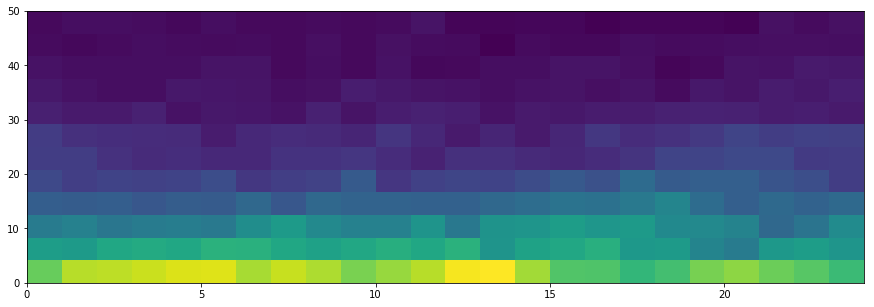

In [109]:
plt.hist2d(x.dt.hour, y, bins=(24, 12), range=((0, 24), (0, 50)))
plt.show()

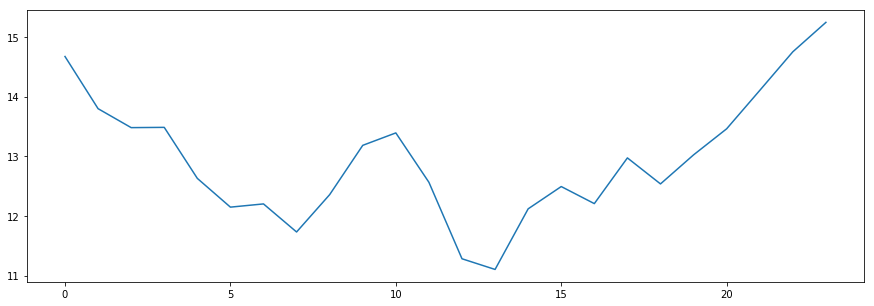

In [110]:
plt.plot(x_avg, y_avg)
plt.show()